In [1]:
#python imports
import ast
import re
import shutil
import os
import math
import copy
import time

#torch imports
import torch
import torchvision.transforms as transforms
from torchvision.utils import save_image, make_grid
from torchvision import datasets
from torchvision.datasets import VisionDataset
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch

#other imports
import pandas 
import cv2
import matplotlib.pyplot as plt
import numpy as np
import sklearn as sk

#custom imports 
from modules.dataloader import TlkWaterMetersDataset, create_dl
from modules.utils import get_bb_from_location_dict, draw_bb_from_coordinates, get_iou_batch, print_bb_prediction,show, efficient_bb_aug
from modules.utils import create_resized_imgs_folder, get_dict_from_string

# Tabular preprocessing 
### Here some preprocessing steps are performed with the data.tsv file. We basically reorder the indexes according to each image id and then extract bounding box coordinates with the polygon information given in the "location" dictionary. The coordinates for bounding boxes are [xa, ya, xb, yb], where points (xa, ya) and (xb,yb) are opposite vetices of the rectangle forming the bounding box, and xb>xa and yb>ya.

In [2]:
#reads .tsv data as dataframe
df=pandas.read_csv('TlkWaterMeters/data.tsv',sep='\t')
#display(df)

In [3]:
#create index column with indexes extracted  from photo_name column
df['index'] = df.apply(lambda x: int(x['photo_name'].split('_')[1]), axis=1)
#reorders dataframe according to index, and selects only necessary columns
df = df.sort_values(by=['index']).reindex()
df = df.reset_index()
df = df.reindex(columns=['photo_name', 'location'])
#display(df)

In [4]:
df['location'] = df.apply(lambda x: get_dict_from_string(x['location']), axis=1)
#print("\n 'type' value at first 'location' dict:", df['location'][0]['type'])
#print("\n 'data' value at first 'location' dict:", df['location'][0]['data'])
#display(df)

In [5]:
print('example: bounding box points obtained with the first location dict')
get_bb_from_location_dict(df['location'][0])

example: bounding box points obtained with the first location dict


[0.40331, 0.2602, 0.696, 0.31293]

In [6]:
#creates a column for bounding box coordinates extracted from location column
df['bb_coordinates'] = df.apply(lambda x: get_bb_from_location_dict(x['location']), axis=1)
print("Final preprocessed df")
display(df)

Final preprocessed df


photo_name  \
0          id_1_value_13_116.jpg   
1         id_2_value_495_341.jpg   
2         id_3_value_366_885.jpg   
3         id_4_value_352_676.jpg   
4         id_5_value_100_533.jpg   
...                          ...   
1239    id_1240_value_28_306.jpg   
1240  id_1241_value_6244_155.jpg   
1241   id_1242_value_209_385.jpg   
1242    id_1243_value_13_474.jpg   
1243    id_1244_value_36_984.jpg   

                                               location  \
0     {'type': 'polygon', 'data': [{'x': 0.40331, 'y...   
1     {'type': 'polygon', 'data': [{'x': 0.26521, 'y...   
2     {'type': 'polygon', 'data': [{'x': 0.24486, 'y...   
3     {'type': 'polygon', 'data': [{'x': 0.2969, 'y'...   
4     {'type': 'polygon', 'data': [{'x': 0.32221, 'y...   
...                                                 ...   
1239  {'type': 'polygon', 'data': [{'x': 0.18313, 'y...   
1240  {'type': 'polygon', 'data': [{'x': 0.1009, 'y'...   
1241  {'type': 'polygon', 'data': [{'x': 0.39923, 'y...   
1242  {'type': 'polygon', 'data': [{'x': 0.29547, 'y...   
1243  {'type': 'polygon', 'data': [{'x': 0.31253, 'y...   

                            bb_coordinates  
0        [0.40331, 0.2602, 0.696, 0.31293]  
1     [0.26521, 0.51579, 0.81973, 0.58409]  
2     [0.24486, 0.33547, 0.74883, 0.44842]  
3     [0.28836, 0.41072, 0.59931, 0.52123]  
4     [0.31796, 0.58737, 0.61947, 0.65029]  
...                                    ...  
1239  [0.18313, 0.41536, 0.76366, 0.49642]  
1240   [0.1009, 0.24786, 0.58399, 0.39055]  
1241  [0.39923, 0.46298, 0.75756, 0.51931]  
1242  [0.29547, 0.16168, 0.74424, 0.22896]  
1243   [0.30182, 0.46691, 0.67597, 0.5741]  

[1244 rows x 3 columns]


# Image preprocessing 
### Here we preprocess the images originally located at 'TlkWaterMeters/images/' into a format more easily managable. We save the preprocessed images in 'images_preprocessed'. The preprocessing only performs a resizing to resolution 256x256. The preprocessed images will be uploaded alongside this notebook as a zip file named "images_preprocessed.zip" and don't need to be preprocessed again, only decompressed. To perform the preprocess again directly on the original dataset, the cell bellow should be uncommented. 

In [7]:
original_path = 'TlkWaterMeters/images/'
preprocessed_path = 'images_preprocessed'
os.makedirs(preprocessed_path, exist_ok=True)
image_files = list(df['photo_name'])

In [8]:
#uncomment to perform image preprocessing
#resizes images and saves them the preprocessed folder
#approx 1 min running time
#create_resized_imgs_folder(preprocessed_path, original_path, image_files, resized_dimensions = 256)

# Pytorch custom dataloader 
### Here we split the data and create the dataloaders training, validation and test. We use pytorch's color augmentations that randomly alter brightness, contrast and hue. We defined a custom vision dataset class for the TlkDataset so that the dataloader is able to handle multiple targets per example.

In [9]:
np.random.seed(3)
random_idxs = np.arange(len(df))
np.random.shuffle(random_idxs)
data_len = len(random_idxs)

train_idxs = random_idxs[:int(0.6*data_len)]
val_idxs = random_idxs[int(0.6*data_len): int(0.8*data_len)]
test_idxs = random_idxs[int(0.8*data_len):]

dl_train = create_dl(df.loc[train_idxs], img_folder = preprocessed_path, use_color_aug=True, shuffle=True)
dl_val = create_dl(df.loc[val_idxs], img_folder = preprocessed_path, use_color_aug=True, drop_last=False, shuffle=False)
dl_test = create_dl(df.loc[test_idxs], img_folder = preprocessed_path, use_color_aug=False, drop_last=False, shuffle=False)

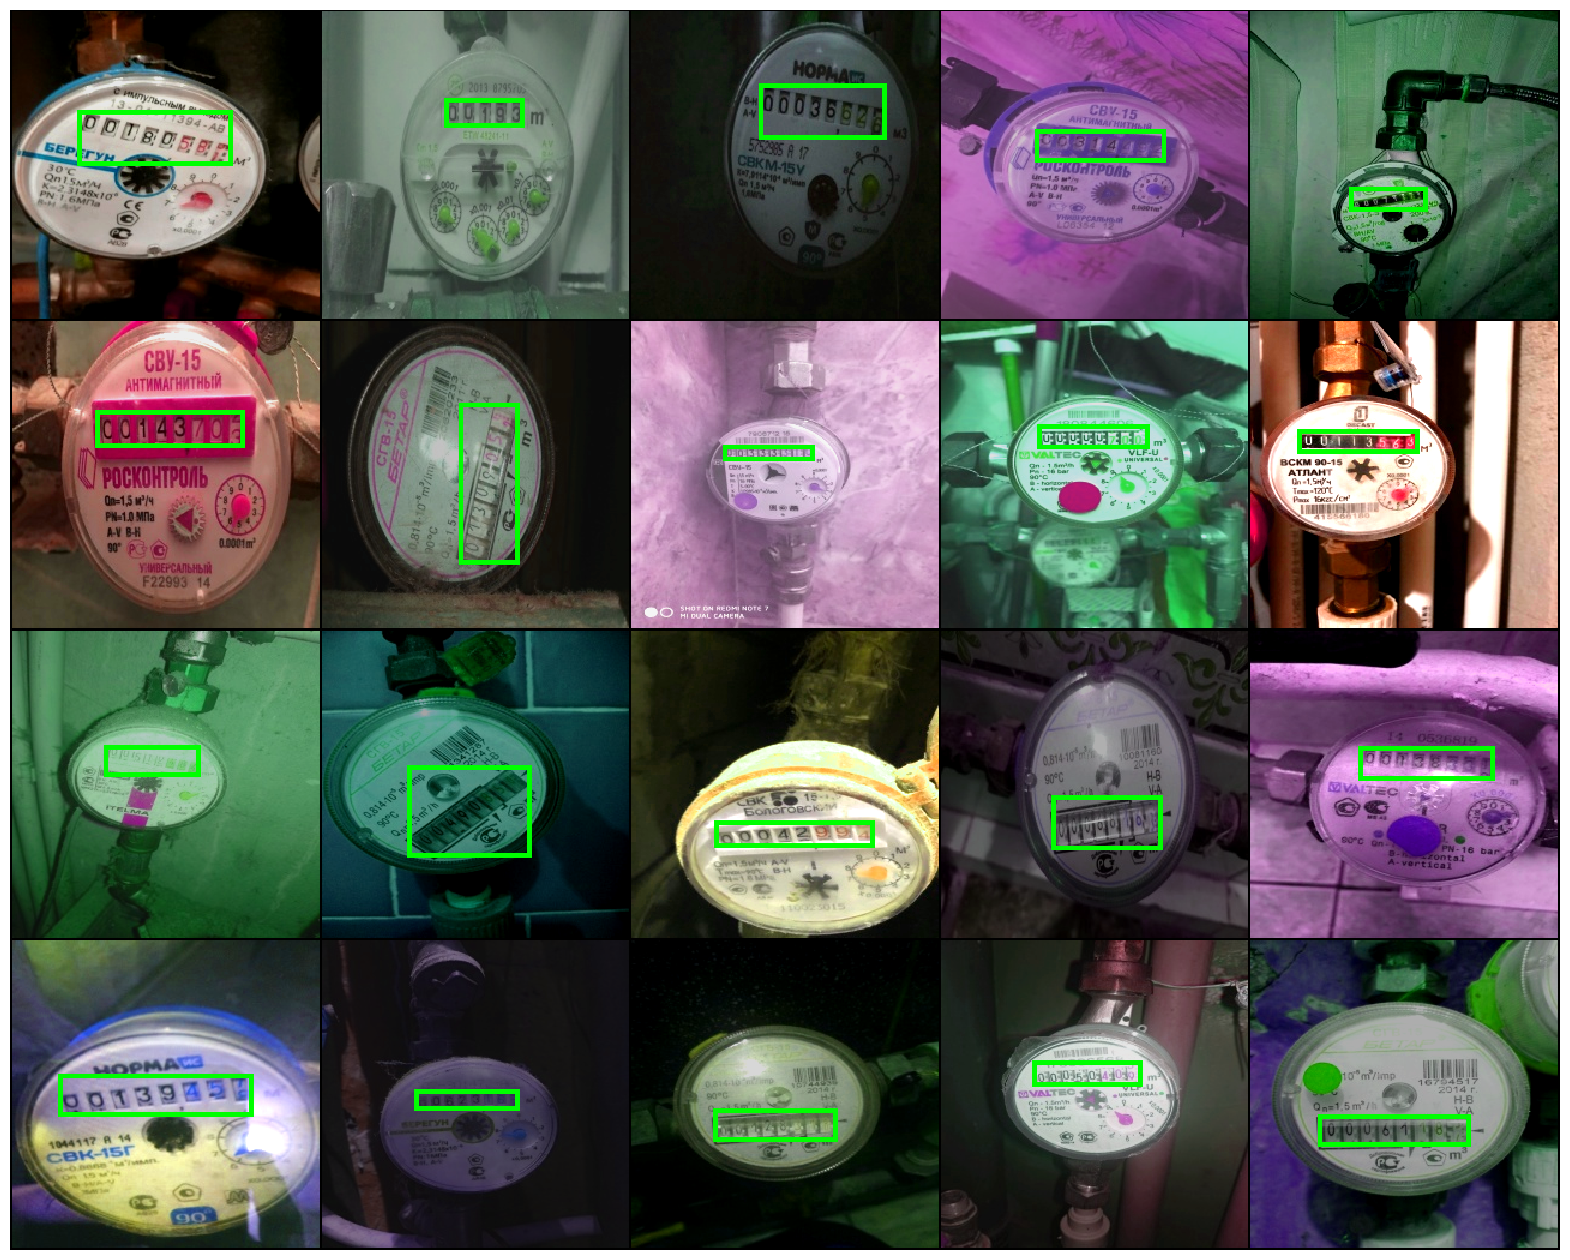

In [10]:
#Some samples showing how the images sampled by the dataloader look like, together with the groung-truth bounding boxes.
img_batch, bb_batch = next(iter(dl_train))
img_size = img_batch.shape[-1]
bb_batch = (bb_batch*img_size).type(torch.int32)
for bb, img in zip(bb_batch, img_batch):
    draw_bb_from_coordinates(img, bb = bb)
grid = make_grid(img_batch[:20].cpu(), nrow=5, normalize=True)
show(grid, 40)

# Spatial Augmentations for Bounding Box and Image
### Here we display a customized set of augmentations applied after the dataloader which will be used for training. These augmentations rotate and invert the images and simultaneously update the bounding box coordinates. Some samples before and after these augmentations are ploted bellow. 

original batch


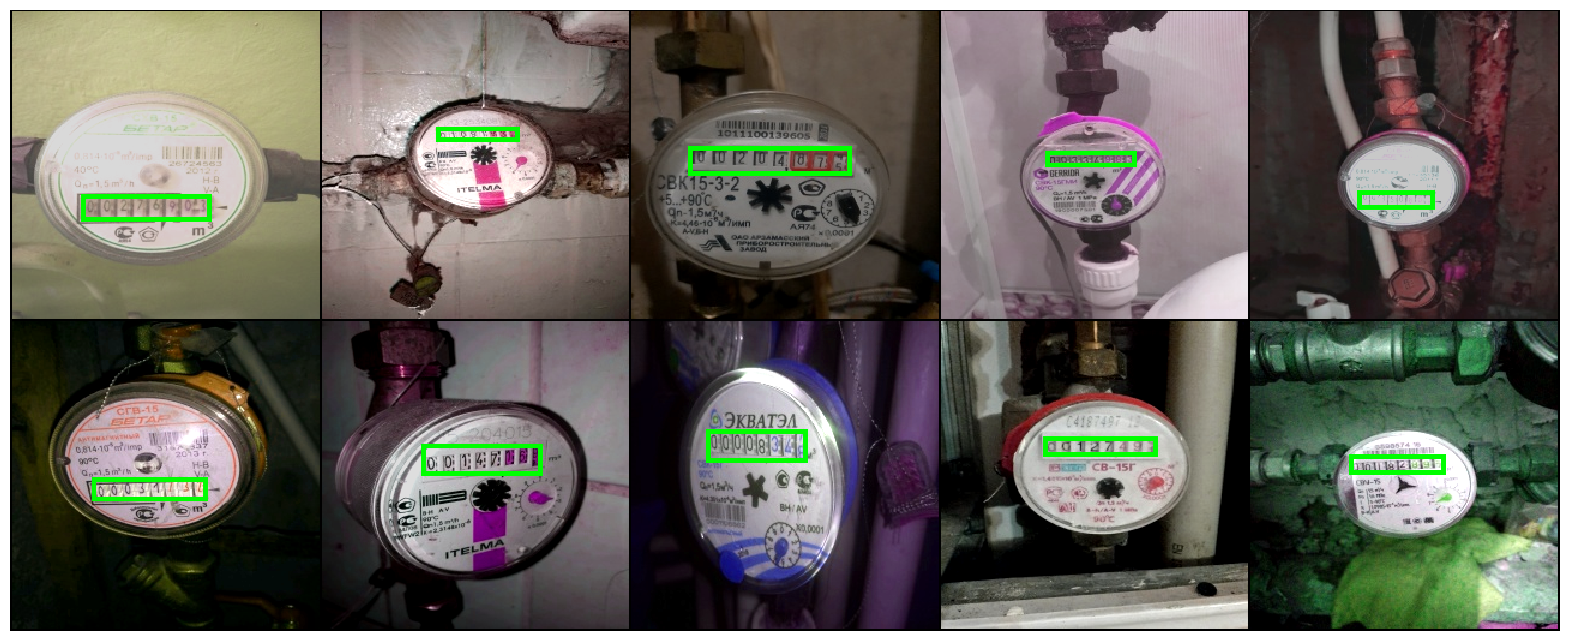

random flip and rotation augmentation


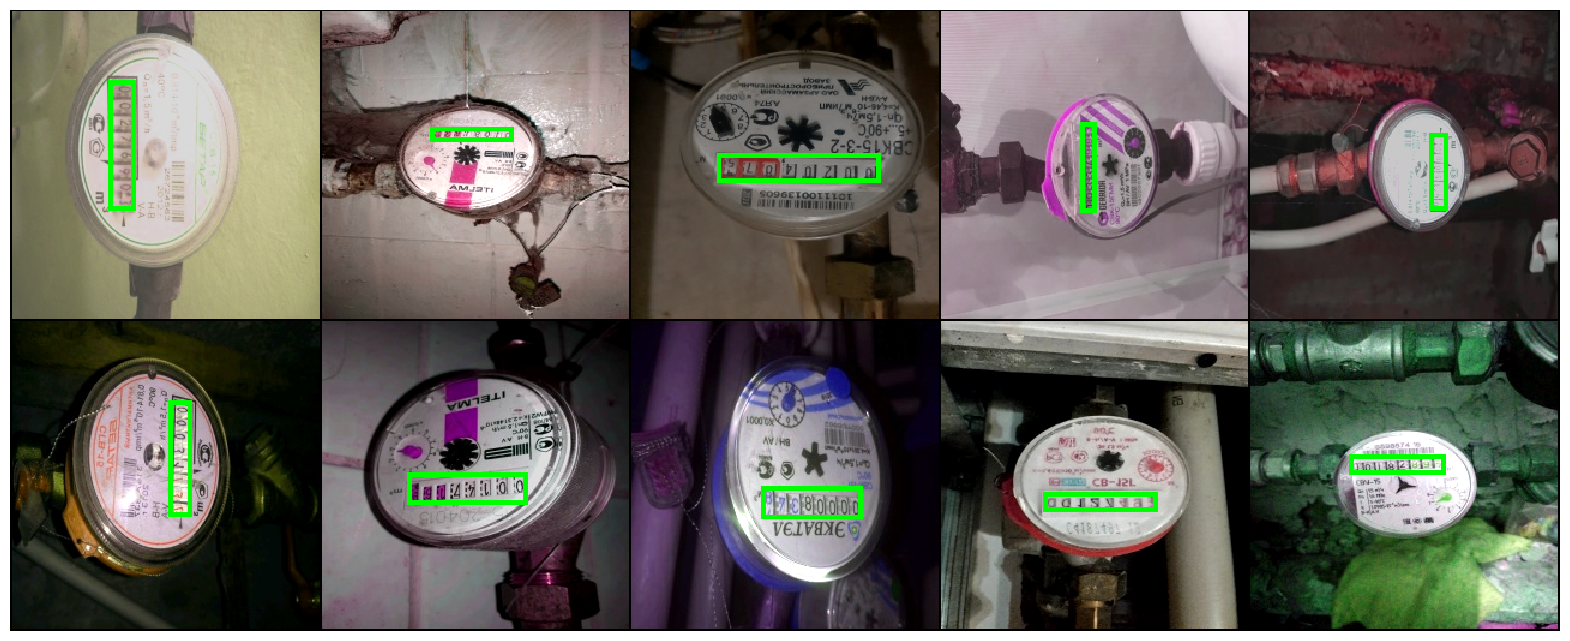

In [11]:
img_batch, bb_batch = next(iter(dl_train))
img_size = img_batch.shape[-1]
img_batch_aug = copy.deepcopy(img_batch)
bb_batch_aug = copy.deepcopy(bb_batch)
img_batch_aug, bb_batch_aug = efficient_bb_aug(img_batch_aug, bb_batch_aug)
bb_batch = (bb_batch*img_size).type(torch.int32)
bb_batch_aug = (bb_batch_aug*img_size).type(torch.int32)
for bb, img in zip(bb_batch, img_batch):
    draw_bb_from_coordinates(img, bb = bb)
for bb, img in zip(bb_batch_aug, img_batch_aug):
    draw_bb_from_coordinates(img, bb = bb)
print('original batch')
grid = make_grid(img_batch[:10].cpu(), nrow=5, normalize=True)
show(grid, 10)
print('random flip and rotation augmentation')
grid = make_grid(img_batch_aug[:10].cpu(), nrow=5, normalize=True)
show(grid, 10)

# Model creation
### Here we define the model, a common regressor with a resnet backbone pretrained on imagenet. The model predicts the bounding box coordinates (xa, ya) and (xb,yb) for a given image. This model was inspired by this tutorial: https://towardsdatascience.com/bounding-box-prediction-from-scratch-using-pytorch-a8525da51ddc

In [12]:
class BB_Regressor(nn.Module):
    def __init__(self):
        super(BB_Regressor, self).__init__()
        resnet = torchvision.models.resnet34(pretrained=True)
        layers = list(resnet.children())[:8]
        self.features1 = nn.Sequential(*layers[:6])
        self.features2 = nn.Sequential(*layers[6:])
        self.bb_regressor = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 4))
        
    def forward(self, x):
        x = self.features1(x)
        x = self.features2(x)
        x = F.relu(x)
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1)
        x = self.bb_regressor(x)
        return x

# Model training
### This training function was also inspired by https://towardsdatascience.com/bounding-box-prediction-from-scratch-using-pytorch-a8525da51ddc. We additionally compute index-over-union (iou) metric for the bounding box, displaying the average and standard deviation of iou for training set and validation set. We also compute iou accuracy, where iou of 0.5 is used as threshold for a correct output. This training requires gpu, and takes approximately 8 seconds per epoch with a rtx 3070 gpu. After each epoch, some image samples and their predicted bounding boxes are saved in a folder passed as argument.

In [13]:
def train_epocs(model, optimizer, dl_train, dl_val, epochs=10, prev_epochs = 0, use_aug=True, 
                save_path='training_output'):
    idx = 0
    if save_path is not None:
        os.makedirs(save_path, exist_ok=True)
    for i in range(epochs):
        start = time.time()
        model.train()
        total = 0
        sum_loss = 0
        iou = []
        for x, y_bb in dl_train:
            x = x.cuda()
            batch_size = y_bb.shape[0]
            y_bb = y_bb.cuda()
            #augmentation
            if use_aug:
                x, y_bb = efficient_bb_aug(x, y_bb)
            pred_bb = model(x)
            #gets loss
            loss_bb = F.mse_loss(pred_bb, y_bb, reduction='none').sum(1)
            loss_bb = loss_bb.sum()
            optimizer.zero_grad()
            loss_bb.backward()
            optimizer.step()
            #gets intersection over union (iou)
            iou_batch = get_iou_batch(y_bb, pred_bb).detach()
            iou.append(iou_batch)
            idx += 1
            total += batch_size
            sum_loss += loss_bb.item()
        train_loss = sum_loss/total
        #intersection over union metric
        iou = torch.cat(iou)
        train_iou_avg = iou.mean().item()
        train_iou_std = iou.std().item()
        train_iou_acc = (iou>0.5).sum().item()/len(iou)
        #validation metrics
        val_loss, val_iou_avg, val_iou_std, val_iou_acc = eval_dl(model, dl_val, use_aug=use_aug)
        #print of epoch metrics 
        print("Epoch {} Running Time {:.4f} sec".format(i+prev_epochs, time.time()-start))
        print("Train metrics: mse_loss {:.4f} avg_iou {:.4f} std_iou {:.4f} acc_iou {:.4f}".format(
            train_loss, train_iou_avg, train_iou_std, train_iou_acc))
        print("Valid metrics: mse_loss {:.4f} avg_iou {:.4f} std_iou {:.4f} acc_iou {:.4f}".format(
            val_loss, val_iou_avg, val_iou_std, val_iou_acc))
        #saves sample images with predicted bb
        if save_path is not None:
            imgs_save_path = os.path.join(save_path, 'images_bb_samples')
            os.makedirs(imgs_save_path, exist_ok=True)
            path_save_train =  os.path.join(imgs_save_path, 'ep_{}_train.jpg'.format(i+prev_epochs))
            print_bb_prediction(model, dl_train, path_save_train)
            path_save_val =  os.path.join(imgs_save_path, 'ep_{}_validation.jpg'.format(i+prev_epochs))
            print_bb_prediction(model, dl_val, path_save_val)
    #saves model state dict
    if save_path is not None:
        model_save_path = os.path.join(save_path, 'model_pretrained')
        os.makedirs(model_save_path, exist_ok=True)
        model_save_path = os.path.join(model_save_path, 'obj_rec_model.pth')
        torch.save(model.state_dict(), model_save_path)
    return sum_loss/total, epochs

def eval_dl(model, dl_val, use_aug=False, use_gpu = True):
    model.eval()
    total = 0
    sum_loss = 0
    correct = 0 
    iou = []
    for i, (x, y_bb) in enumerate(dl_val):
        batch_size = y_bb.shape[0]
        if use_gpu:
            x = x.cuda()
            y_bb = y_bb.cuda()
        if use_aug:
            x, y_bb = efficient_bb_aug(x, y_bb)
        pred_bb = model(x)
        #gets loss
        loss_bb = F.mse_loss(pred_bb, y_bb, reduction='none').sum(1)
        loss_bb = loss_bb.sum()
        sum_loss += loss_bb.item()
        total += batch_size
        #gets intersection over union (iou)
        iou_batch = get_iou_batch(y_bb, pred_bb).detach()
        iou.append(iou_batch)
    val_loss = sum_loss/total
    #intersection over union metrics
    iou = torch.cat(iou)
    iou_avg = iou.mean().item()
    iou_std = iou.std().item()
    iou_acc = (iou>0.5).sum().item()/len(iou)
    return val_loss, iou_avg, iou_std, iou_acc

In [14]:
save_path = 'training_outputs'
model = BB_Regressor().cuda()
parameters = filter(lambda p: p.requires_grad, model.parameters())
optimizer = torch.optim.Adam(parameters, lr=0.0001)

In [15]:
#uncomment for loading the model
'''model_pretrained_path = os.path.join(save_path, 'model_pretrained/obj_rec_model.pth')
model.load_state_dict(torch.load( model_pretrained_path))'''

"model_save_path = 'pretrained_model'\nmodel.load_state_dict(torch.load( os.path.join(model_save_path, 'od_model.pth')))"

In [16]:
loss, epochs = train_epocs(model, optimizer, dl_train, dl_val, epochs=150, prev_epochs = 0, save_path=save_path)
previous_epochs+=epochs

Epoch 0 Running Time 8.5762 sec
Train metrics: mse_loss 2.0091 avg_iou 0.0011 std_iou 0.0128 acc_iou 0.0000
Valid metrics: mse_loss 2.2770 avg_iou 0.0000 std_iou 0.0000 acc_iou 0.0000
Epoch 1 Running Time 7.9514 sec
Train metrics: mse_loss 1.5490 avg_iou 0.0002 std_iou 0.0028 acc_iou 0.0000
Valid metrics: mse_loss 1.8047 avg_iou 0.0000 std_iou 0.0000 acc_iou 0.0000
Epoch 2 Running Time 7.9953 sec
Train metrics: mse_loss 1.3559 avg_iou 0.0000 std_iou 0.0009 acc_iou 0.0000
Valid metrics: mse_loss 1.4973 avg_iou 0.0000 std_iou 0.0000 acc_iou 0.0000
Epoch 3 Running Time 8.0259 sec
Train metrics: mse_loss 1.2350 avg_iou 0.0000 std_iou 0.0000 acc_iou 0.0000
Valid metrics: mse_loss 0.9619 avg_iou 0.0017 std_iou 0.0257 acc_iou 0.0000
Epoch 4 Running Time 8.0383 sec
Train metrics: mse_loss 1.1695 avg_iou 0.0000 std_iou 0.0000 acc_iou 0.0000
Valid metrics: mse_loss 1.0192 avg_iou 0.0005 std_iou 0.0078 acc_iou 0.0000
Epoch 5 Running Time 8.0379 sec
Train metrics: mse_loss 1.1034 avg_iou 0.0000 st

# Test eval
### Here we perform the final evaluation, using the test set. This code runs on CPU and takes about 2 seconds for the entire test set. We can see the final results are mse_loss 0.0058 avg_iou 0.4945 std_iou 0.2381 acc_iou 0.5502. Additionally, 64 test image samples and their predicted bounding boxes are saved in a folder named 'test_bb_samples' inside the training_output path

In [18]:
#uncomment for loading the model
'''model_pretrained_path = os.path.join(save_path, 'model_pretrained/obj_rec_model.pth')
model.load_state_dict(torch.load( model_pretrained_path))'''

"model_save_path = 'pretrained_model'\nmodel.load_state_dict(torch.load( os.path.join(model_save_path, 'od_model.pth')))"

In [19]:
model = model.cpu()
test_loss, test_iou_avg, test_iou_std, test_iou_acc = eval_dl(model, dl_test, use_aug=False, use_gpu=False)
print("Test metrics: mse_loss {:.4f} avg_iou {:.4f} std_iou {:.4f} acc_iou {:.4f}".format(
    test_loss, test_iou_avg, test_iou_std, test_iou_acc))

Test metrics: mse_loss 0.0058 avg_iou 0.4945 std_iou 0.2381 acc_iou 0.5502


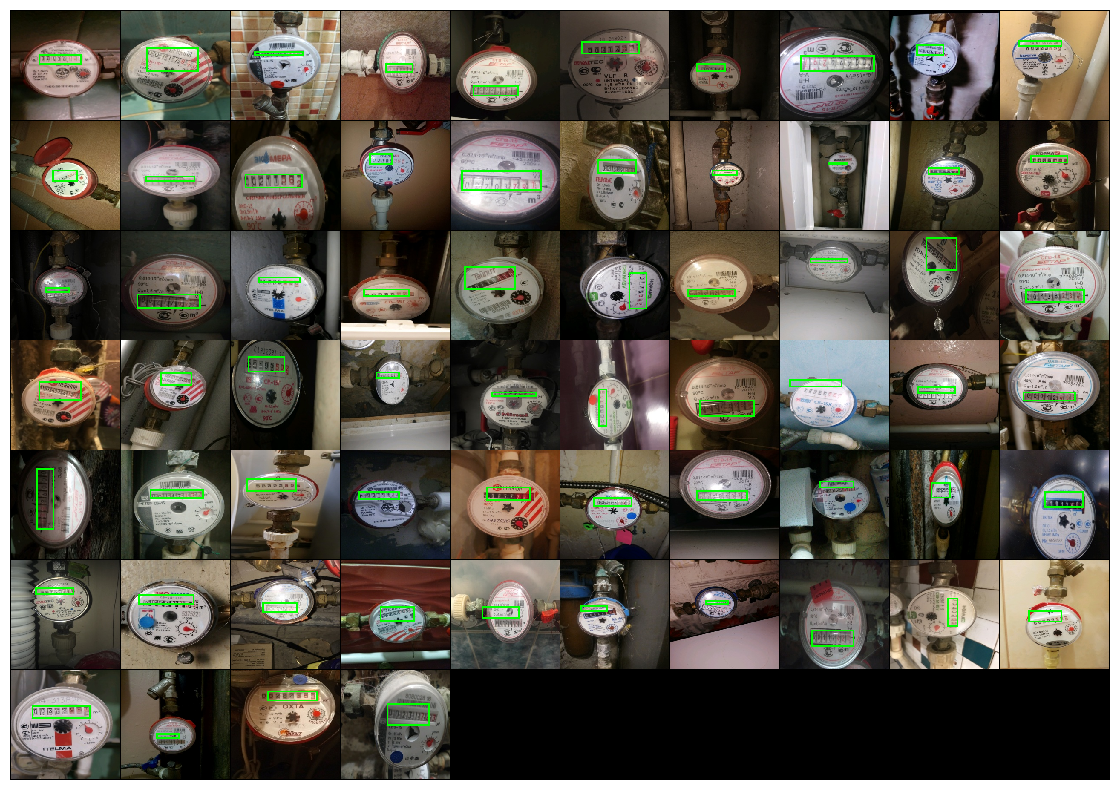

In [28]:
#print and save batch of test images with predicted bbs
test_samples_path = os.path.join(save_path, 'test_bb_samples')
os.makedirs(test_samples_path, exist_ok=True)
test_samples_path =  os.path.join(test_samples_path, 'test_bb_samples.jpg')
x, _ = next(iter(dl_test))
no_samples = 64
img_size = x.shape[-1]
pred_bb = model(x)
pred_bb = pred_bb.clip(0,1)
pred_bb = (pred_bb*img_size).type(torch.int32)
for bb, img in zip(pred_bb, x):
    draw_bb_from_coordinates(img, bb = bb)
grid = make_grid(x[:no_samples].cpu(), nrow=10, normalize=True)
show(grid, 10)
save_image(grid, test_samples_path)
print("Test set sample and their predicted bounding boxes")